In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import warnings; warnings.simplefilter('ignore')
import sys
sys.path.insert(0, '/Users/jsmonzon/Research/SatGen/mcmc/src/')
import jsm_halopull
import jsm_SHMR
import jsm_mcmc
import jsm_stats
import jsm_models

In [3]:
plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['axes.grid'] = False
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.labelsize'] = 15
plt.rc('legend',fontsize=12)
plt.rcParams['axes.linewidth'] = 2

In [4]:
lgMh_full = np.vstack(np.load("../../../data/MW-analog/meta_data_psi4/models.npz")["mass"])
red_full = np.vstack(np.load("../../../data/MW-analog/meta_data_psi4/models.npz")["redshift"])
halo_masses = np.linspace(8,12,100) # just for the model

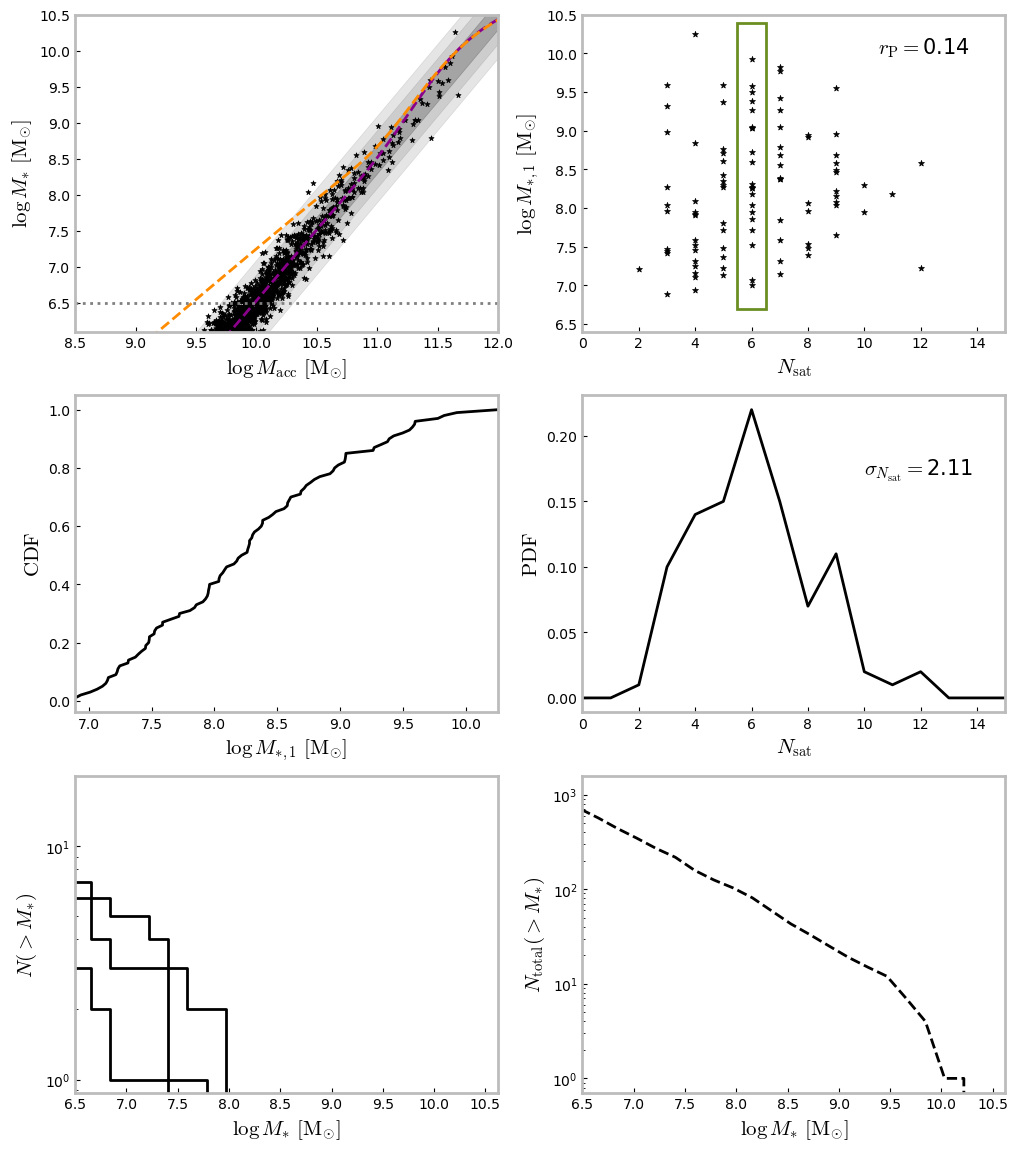

In [5]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, figsize=(12,14))

colorpick="black"

theta = [10.5, 2.0, 0.2, 0, 0, 0]
theta_det = theta[:2] + [0, 0] + theta[4:]
sigma = theta[2] + theta[3]*(halo_masses-12)

lgMs_full = jsm_SHMR.general(theta, lgMh_full, red_full, 1)
det = jsm_SHMR.general(theta_det, halo_masses, 0, 1)

lgMh_example = lgMh_full[0:100]
lgMs_example = lgMs_full[0:100]
stat = jsm_stats.SatStats_D(lgMs_example, min_mass=6.5)
nad_stat = jsm_stats.SatStats_NAD_D(lgMs_example, min_mass=6.0, N_bin=25)

ax1.fill_between(halo_masses, det - sigma, det + sigma, color=colorpick, alpha=0.2)
ax1.fill_between(halo_masses, det - 2 * sigma, det + 2 * sigma, color=colorpick, alpha=0.1)
ax1.fill_between(halo_masses, det - 3 * sigma, det + 3 * sigma, color=colorpick, alpha=0.1)

ax1.scatter(lgMh_example.flatten(), lgMs_example.flatten(), marker="*", s=15, color=colorpick)

ax1.plot(halo_masses, jsm_SHMR.lgMs_RP17(halo_masses), color="darkmagenta", ls="--", label="Rodriquez-Puebla et al. 2017")
ax1.plot(halo_masses, jsm_SHMR.lgMs_B13(halo_masses), color="darkorange", ls="--", label="Behroozi et al. 2013")
ax1.axhline(6.5, color="grey", ls=":", label="magnitude limit")
ax1.set_xlim(8.5,12)
ax1.set_ylim(6.1,10.5)
ax1.set_ylabel("$\log M_{*}\ [\mathrm{M}_{\odot}]$")
ax1.set_xlabel("$\log M_{\mathrm{acc}}\ [\mathrm{M}_{\odot}]$")
#ax1.legend(fontsize=12)

rect = patches.Rectangle((5.5, 6.7), 1, 3.7, linewidth=2, edgecolor='olivedrab', facecolor="None")

ax2.scatter(stat.Nsat_perhost, stat.maxmass, color=colorpick, s=20, marker="*")
ax2.add_patch(rect)
ax2.text(10.5, 10, "$r_{\mathrm{P}} =$"+f"{stat.correlation:.2f}", fontsize=15)
ax2.set_ylabel("$\log M_{*,1}\ [\mathrm{M}_{\odot}]$")
ax2.set_xlabel("$N_{\mathrm{sat}}$")
ax2.set_xlim(0,15)
ax2.set_ylim(6.4,10.5)

ax3.plot(np.sort(stat.maxmass), jsm_stats.ecdf(np.sort(stat.maxmass)),color=colorpick)
ax3.set_xlabel("$\log M_{*,1}\ [\mathrm{M}_{\odot}]$")
ax3.set_ylabel("$\mathrm{CDF}$")
ax3.set_xlim(stat.maxmass.min(),stat.maxmass.max())


ax4.plot(stat.PNsat_range, stat.PNsat, color=colorpick)
ax4.text(10, 0.17, "$\sigma_{N_{\mathrm{sat}}} =$"+f"{stat.sigma_N:.2f}", fontsize=15)
ax4.set_xlabel("$N_{\mathrm{sat}}$")
ax4.set_ylabel("$\mathrm{PDF}$")
ax4.set_xlim(0,15)

for i in np.random.randint(0,100,3):
    ax5.step(nad_stat.bin_centers, nad_stat.count_mat_cum[i], color=colorpick)
ax5.set_ylabel("$N (>  M_{*})$")
ax5.set_xlabel("$\log M_{*}\ [\mathrm{M}_{\odot}]$")
ax5.set_yscale("log")
ax5.set_ylim(0,2e1)
ax5.set_xlim(6.5)

ax6.plot(nad_stat.bin_centers, nad_stat.stack_cum, color=colorpick, ls="--")
ax6.set_ylabel("$ N_{\mathrm{total}} (>  M_{*})$")
ax6.set_xlabel("$\log M_{*}\ [\mathrm{M}_{\odot}]$")
ax6.set_yscale("log")
ax6.set_xlim(6.5)

plt.savefig("../../../paper_1/figures/updated/summary_stats.pdf", bbox_inches="tight")
plt.show()

# ax1.plot(x, y)
# ax3.plot(x, y**2, 'tab:orange')
# ax3.plot(x, -y, 'tab:green')
# ax4.plot(x, -y**2, 'tab:red')